Parameters have to be changed for every stock and contract based on priors 
1. Get real time feeds from fidelity csv options page
2. Find way to impliment grach into volatility increasing for single leg trades exit / entry
3. add HMM filter for up/down regime detection to limit spike losses 

In [1]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [2]:
datafix = datafix.set_index("Date")

In [3]:
datafix["sma30"] = datafix["Close"].rolling(30).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"] 

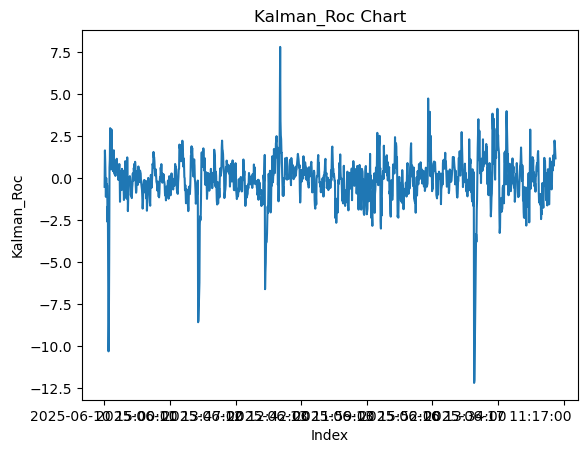

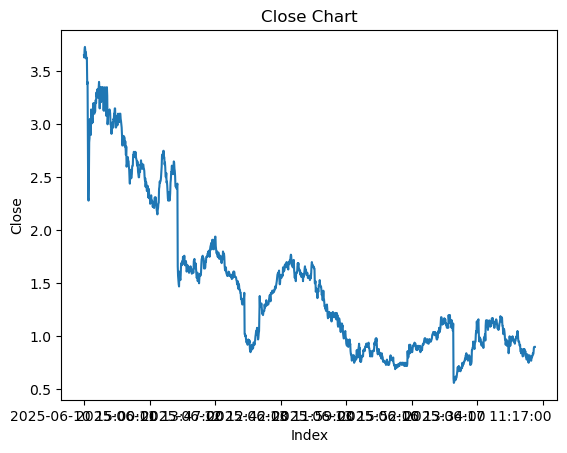

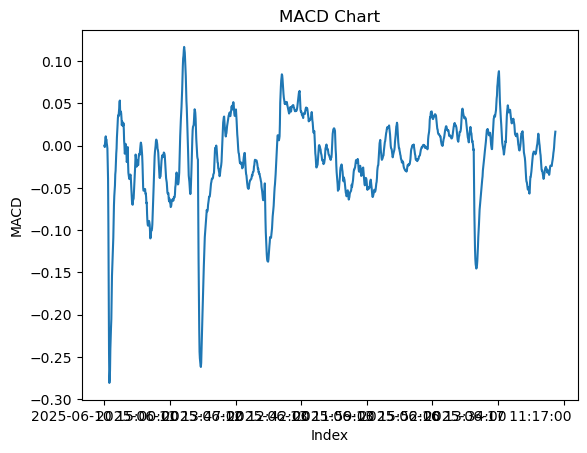

Column 'RSI' not found in datafix DataFrame.
Column 'IV_garch_vol' not found in datafix DataFrame.
Column 'GarchRoc' not found in datafix DataFrame.


In [4]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")
plot("Kalman_Roc")
plot("Close")
plot("MACD")
plot("RSI")
plot("IV_garch_vol")
plot("GarchRoc")

In [5]:
import numpy as np

# Standardize MACD_Hist using a rolling window (e.g., 50 periods)
window = 20
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)


In [6]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Assume 'Kalman_Roc' is already in datafix and contains the filtered returns
# Drop NaN values to ensure clean input for the HMM
kalman_roc_values = datafix['Kalman_Roc'].dropna().values.reshape(-1, 1)

# Fit a 2-state Gaussian HMM
hmm_model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000)
hmm_model.fit(kalman_roc_values)

# Predict the hidden states (regimes)
hidden_states = hmm_model.predict(kalman_roc_values)

# Align the states with the original dataframe
states_full = np.full(len(datafix), np.nan)
states_full[datafix['Kalman_Roc'].notna()] = hidden_states

# Append the regime state to the dataframe
datafix['regime_state'] = states_full


In [7]:
from arch import arch_model

# Drop NaN values from 'IV' for modeling
iv_series = datafix['IV'].dropna()

# Fit a GARCH(1,1) model to the IV series
model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# Get the conditional variance (volatility estimate) for each point
conditional_variance = model_fit.conditional_volatility

# Align the conditional volatility with the original dataframe's index
# This will fill NaN for rows where 'IV' was NaN
datafix['IV_garch_vol'] = conditional_variance.reindex(datafix.index)
datafix["GarchRoc"] = datafix['IV_garch_vol'].pct_change()
datafix["GarchRoc5sma"] = datafix["GarchRoc"].rolling(3).mean()
datafix["GarchSma"] = datafix['IV_garch_vol'].rolling(14).mean()
datafix["GarchSmaSpread"] = datafix['IV_garch_vol']-datafix["GarchSma"]
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
spread_values = datafix['GarchSmaSpread'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler = StandardScaler()
standardized_spread = scaler.fit_transform(spread_values)

# Add the standardized spread back to the dataframe
datafix['GarchSmaSpread_std'] = standardized_spread
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc5sma_values = datafix['GarchRoc5sma'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_roc5sma = StandardScaler()
standardized_roc5sma = scaler_roc5sma.fit_transform(garchroc5sma_values)

# Add the standardized GarchRoc5sma back to the dataframe
datafix['GarchRocsma_std'] = standardized_roc5sma
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc_values = datafix['GarchRoc'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_garchroc = StandardScaler()
standardized_garchroc = scaler_garchroc.fit_transform(garchroc_values)

# Add the standardized GarchRoc back to the dataframe
datafix['GarchRoc_std'] = standardized_garchroc


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [8]:
import pandas as pd

def compute_rsi(df, column="Close", period=14):
    # Calculate price differences
    delta = df[column].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to dataframe
    df['RSI'] = rsi
    return df

compute_rsi(datafix)


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,regime_state,IV_garch_vol,GarchRoc,GarchRoc5sma,GarchSma,GarchSmaSpread,GarchSmaSpread_std,GarchRocsma_std,GarchRoc_std,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-10 15:00:00,3.67,3.67,3.65,3.65,5,3.650000,NaN,0.000000,0.000000,0.000000,...,NaN,0.380796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-10 15:02:00,3.62,3.63,3.62,3.63,7,3.631671,-0.502170,-0.001595,-0.000319,-0.001276,...,1.0,0.405506,0.064890,NaN,NaN,NaN,NaN,NaN,4.644982,NaN
2025-06-10 15:04:00,3.72,3.72,3.71,3.71,19,3.692156,1.665505,0.003555,0.000456,0.003099,...,1.0,0.406070,0.001391,NaN,NaN,NaN,NaN,NaN,0.108765,NaN
2025-06-10 15:05:00,3.71,3.75,3.71,3.73,16,3.727166,0.948228,0.009144,0.002193,0.006951,...,1.0,0.412398,0.015583,0.027288,NaN,NaN,NaN,3.491734,1.122631,NaN
2025-06-10 15:06:00,3.74,3.74,3.70,3.70,38,3.722909,-0.114234,0.011026,0.003960,0.007066,...,1.0,0.414526,0.005161,0.007378,NaN,NaN,NaN,0.959085,0.378083,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17 14:54:00,0.82,0.85,0.82,0.85,24,0.823376,1.240587,-0.002439,-0.012886,0.010447,...,1.0,0.278873,-0.010816,0.001605,0.277033,0.001840,0.304518,0.224766,-0.763232,56.618647
2025-06-17 14:56:00,0.89,0.89,0.89,0.89,1,0.841892,2.248787,0.003649,-0.009579,0.013228,...,1.0,0.277475,-0.005013,0.001399,0.277271,0.000204,0.099432,0.198497,-0.348701,62.996960
2025-06-17 14:57:00,0.86,0.90,0.86,0.90,11,0.859077,2.041193,0.009176,-0.005828,0.015004,...,1.0,0.278331,0.003086,-0.004248,0.277672,0.000659,0.156465,-0.519788,0.229870,64.405941


In [9]:
import numpy as np

# Precompute the rolling mean of Kalman_Roc (window=3)
datafix["Kalman_Roc_roll3"] = datafix["Kalman_Roc"].rolling(3).mean()

buy_condition = (
    #(datafix["GarchSmaSpread_std"] < 0) &
    (datafix["Kalman_Roc_roll3"] > 1.) &
    (datafix["regime_state"].rolling(14).sum() <= 6) 
    &(datafix['GarchRoc_std']>1)
   # & (datafix["Volume"].rolling(3).mean() < datafix["Volume"].rolling(12).mean())
)

datafix["Signal"] = None
datafix["max_gain"] = np.nan

in_position = False
current_max = np.nan
signals = [None] * len(datafix)

for int_idx, (df_idx, row) in enumerate(datafix.iterrows()):
    if not in_position:
        if buy_condition.loc[df_idx]:
            signals[int_idx] = "buy"
            in_position = True
            current_max = row["Close"]
            datafix.at[df_idx, "max_gain"] = current_max
    else:
        current_max = max(current_max, row["Close"])
        datafix.at[df_idx, "max_gain"] = current_max
        if (row["Close"] < current_max * 0.80) or (row["Kalman_Roc_roll3"] < -0.50):
            signals[int_idx] = "sell"
            in_position = False
            current_max = np.nan

datafix["Signal"] = signals
datafix["AvgVol"] = datafix["Volume"].rolling(20).mean()


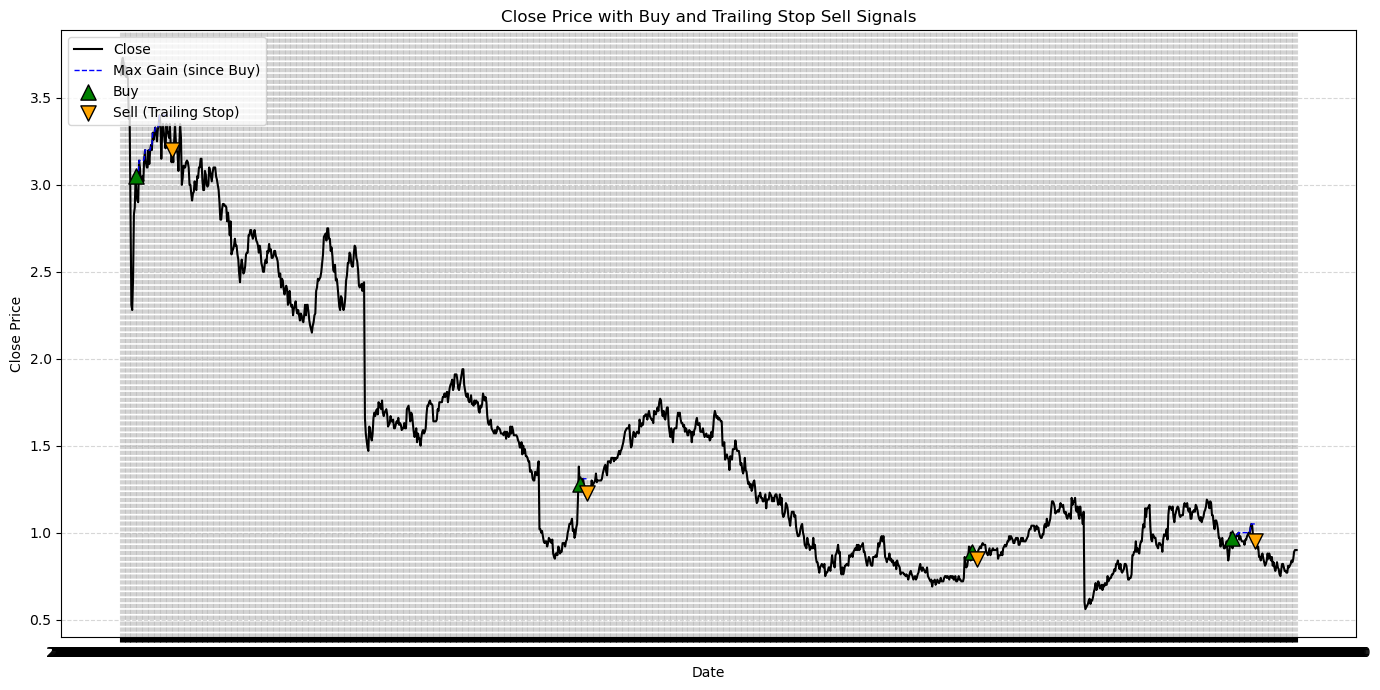

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot the Close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# (Optional) Plot the running max_gain as a blue dashed line
plt.plot(datafix.index, datafix["max_gain"], label="Max Gain (since Buy)", color="blue", linestyle="dashed", linewidth=1)

# Plot buy signals (green upward triangle)
buy_signals = datafix[datafix["Signal"] == "buy"]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Buy", zorder=3)

# Plot sell signals (orange downward triangle)
sell_signals = datafix[datafix["Signal"] == "sell"]
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="orange", edgecolor="black", s=120, label="Sell (Trailing Stop)", zorder=3)

plt.title("Close Price with Buy and Trailing Stop Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



plt.show()


In [11]:
import pandas as pd

# Initialize lists to store trade details
buy_indices = []
sell_indices = []
buy_prices = []
sell_prices = []
buy_dates = []
sell_dates = []

in_position = False

for idx, row in datafix.iterrows():
    if not in_position and row["Signal"] == "buy":
        buy_indices.append(idx)
        buy_prices.append(row["Close"])
        buy_dates.append(row.name)
        in_position = True
    elif in_position and row["Signal"] == "sell":
        sell_indices.append(idx)
        sell_prices.append(row["Close"])
        sell_dates.append(row.name)
        in_position = False

# Ensure pairs are matched correctly
pairs = min(len(buy_prices), len(sell_prices))
buy_indices = buy_indices[:pairs]
sell_indices = sell_indices[:pairs]
buy_prices = buy_prices[:pairs]
sell_prices = sell_prices[:pairs]
buy_dates = buy_dates[:pairs]
sell_dates = sell_dates[:pairs]

# Calculate returns for each trade
returns = [(sell - buy) / buy for buy, sell in zip(buy_prices, sell_prices)]

# Create the 'test' DataFrame with trade details and returns
test = pd.DataFrame({
    "Buy_Index": buy_indices,
    "Sell_Index": sell_indices,
    "Buy_Date": buy_dates,
    "Sell_Date": sell_dates,
    "Buy_Price": buy_prices,
    "Sell_Price": sell_prices,
    "Return": returns
})


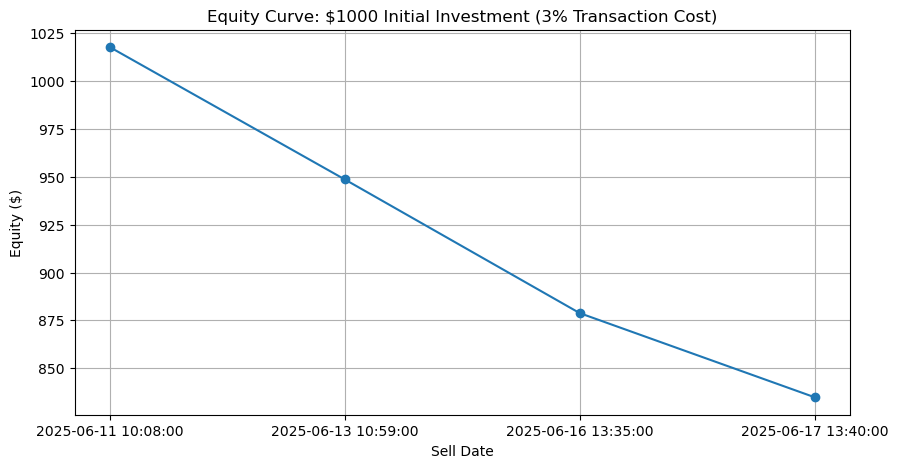

In [12]:
import matplotlib.pyplot as plt

initial_capital = 1000
equity_curve = [initial_capital]

for ret in test["Return"]:
    # Apply 3% transaction cost to each trade
    net_return = (1 + ret) * 0.97  # 3% cost
    equity_curve.append(equity_curve[-1] * net_return)

# Remove the initial capital for plotting (so curve aligns with trades)
equity_curve = equity_curve[1:]
test["Equity"] = equity_curve

plt.figure(figsize=(10,5))
plt.plot(test["Sell_Date"], test["Equity"], marker='o')
plt.title("Equity Curve: $1000 Initial Investment (3% Transaction Cost)")
plt.xlabel("Sell Date")
plt.ylabel("Equity ($)")
plt.grid(True)
plt.show()


In [13]:
"""import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot IV and IV_garch_vol on the left y-axis
ax1.plot(datafix.index, datafix['IV'], label='Implied Volatility (IV)', color='blue')
ax1.plot(datafix.index, datafix['IV_garch_vol'], label='GARCH Volatility (IV_garch_vol)', color='red', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for the close price
ax2 = ax1.twinx()
ax2.plot(datafix.index, datafix['Close'], label='Close Price', color='green', alpha=0.5)
ax2.set_ylabel('Close Price')
ax2.legend(loc='upper right')

plt.title('Implied Volatility, GARCH Volatility, and Close Price')
plt.tight_layout()
plt.show()"""


"import matplotlib.pyplot as plt\n\nfig, ax1 = plt.subplots(figsize=(14, 7))\n\n# Plot IV and IV_garch_vol on the left y-axis\nax1.plot(datafix.index, datafix['IV'], label='Implied Volatility (IV)', color='blue')\nax1.plot(datafix.index, datafix['IV_garch_vol'], label='GARCH Volatility (IV_garch_vol)', color='red', alpha=0.7)\nax1.set_xlabel('Date')\nax1.set_ylabel('Volatility')\nax1.legend(loc='upper left')\nax1.grid(True)\n\n# Create a second y-axis for the close price\nax2 = ax1.twinx()\nax2.plot(datafix.index, datafix['Close'], label='Close Price', color='green', alpha=0.5)\nax2.set_ylabel('Close Price')\nax2.legend(loc='upper right')\n\nplt.title('Implied Volatility, GARCH Volatility, and Close Price')\nplt.tight_layout()\nplt.show()"

In [14]:
"""import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot standardized GARCH SMA spread (left y-axis)
ax1.plot(datafix.index, datafix['GarchSmaSpread_std'], label='Standardized GARCH SMA Spread', color='purple')
ax1.set_ylabel('Standardized GARCH SMA Spread', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot IV on the first secondary y-axis
ax2 = ax1.twinx()
ax2.plot(datafix.index, datafix['IV'], label='Implied Volatility (IV)', color='blue', alpha=0.7)
ax2.set_ylabel('Implied Volatility (IV)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot Close on the second secondary y-axis, offsetting the axis
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))  # Offset the third y-axis
ax3.plot(datafix.index, datafix['Close'], label='Close Price', color='green', alpha=0.5)
ax3.set_ylabel('Close Price', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Add title and grid
plt.title('Standardized GARCH SMA Spread vs. IV and Close Price')
ax1.grid(True)
fig.tight_layout()  # Adjust layout to prevent label overlap

plt.show()"""


'import matplotlib.pyplot as plt\n\nfig, ax1 = plt.subplots(figsize=(14, 7))\n\n# Plot standardized GARCH SMA spread (left y-axis)\nax1.plot(datafix.index, datafix[\'GarchSmaSpread_std\'], label=\'Standardized GARCH SMA Spread\', color=\'purple\')\nax1.set_ylabel(\'Standardized GARCH SMA Spread\', color=\'purple\')\nax1.tick_params(axis=\'y\', labelcolor=\'purple\')\n\n# Plot IV on the first secondary y-axis\nax2 = ax1.twinx()\nax2.plot(datafix.index, datafix[\'IV\'], label=\'Implied Volatility (IV)\', color=\'blue\', alpha=0.7)\nax2.set_ylabel(\'Implied Volatility (IV)\', color=\'blue\')\nax2.tick_params(axis=\'y\', labelcolor=\'blue\')\n\n# Plot Close on the second secondary y-axis, offsetting the axis\nax3 = ax1.twinx()\nax3.spines["right"].set_position(("axes", 1.1))  # Offset the third y-axis\nax3.plot(datafix.index, datafix[\'Close\'], label=\'Close Price\', color=\'green\', alpha=0.5)\nax3.set_ylabel(\'Close Price\', color=\'green\')\nax3.tick_params(axis=\'y\', labelcolor=\'gre